# Clustering and differential expression analysis using scanpy

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import json
import os
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [3]:
dataset_name = 'E175'
data_out_path = './data/{}/scanpy/'.format(dataset_name)
default_path = '{}default/'.format(data_out_path)
celltypist_path = '{}celltypist/'.format(data_out_path)
nclusters_celltypist_path = './data/{}/nclusters.json'.format(dataset_name)

top_number_of_markers = 500
min_cluster_size = 0

with open(nclusters_celltypist_path) as f:
    nclusters_celltypist = json.load(f)['nclusters']

nclusters_threshold = 1/10
min_ncluster_celltypist = round(nclusters_celltypist - nclusters_threshold*nclusters_celltypist)
max_ncluster_celltypist = round(nclusters_celltypist + nclusters_threshold*nclusters_celltypist)

if not os.path.exists(default_path):
    os.makedirs(default_path)

if not os.path.exists(celltypist_path):
    os.makedirs(celltypist_path)

## Data loading and preparation

Dataset loading

In [7]:
adata = sc.read_csv(f'./data/{dataset_name}/CorticalCells_GSM2861514_E175_cleaned.csv', first_column_names=None)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 17085 × 874

Studying feature variance

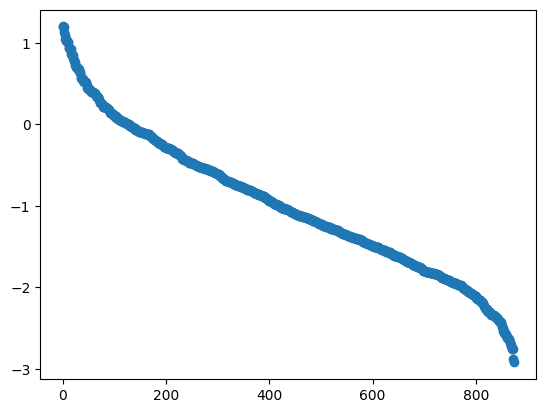

In [9]:
matrix = adata.X
neg_variances = np.sort(-np.var(matrix, axis=0))
sorted_log_variances = [np.log(-i) for i in neg_variances.T][:2000]
plt.scatter([i for i in range(len(sorted_log_variances))], sorted_log_variances)

Data normalization

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Feature selection

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


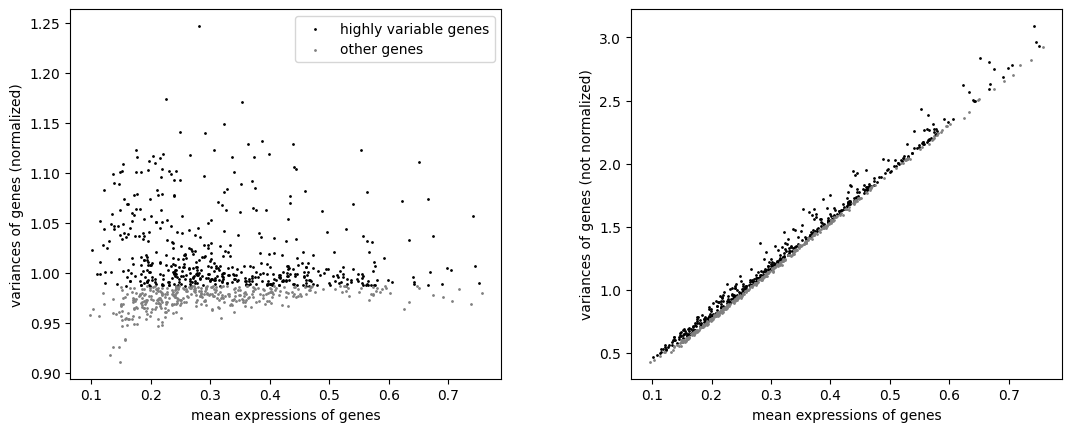

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=500, # chosen based on elbow plot above
    flavor='seurat_v3'
)
sc.pl.highly_variable_genes(adata)

Feature scaling

In [12]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10) # default=None, 10 in the tutorial on pbmc

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Clustering

Plot pca explained variance ratio to choose number of components

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


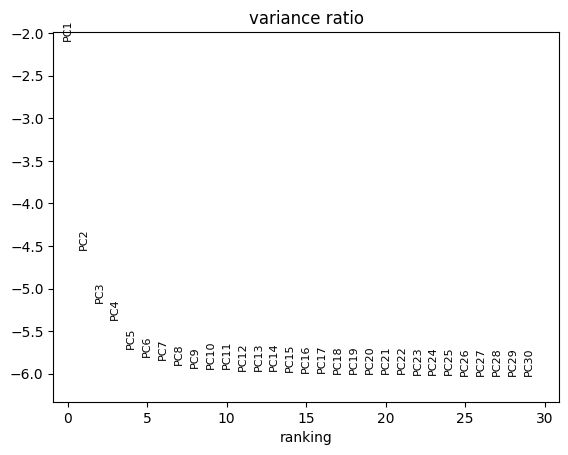

In [13]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=30, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

### Clustering with default parameters

Perform the clustering

In [14]:
sc.pp.neighbors(
    adata,
    n_pcs=10 # chosen based on elbow plot above
)
sc.tl.leiden(adata)

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Visualize the clustering in the PCA space

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


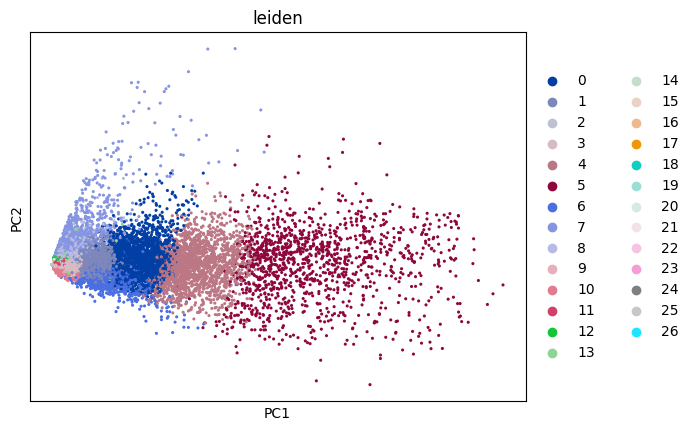

In [15]:
sc.pl.pca(
    adata,
    color=['leiden'],
    size=20
)

Save the clustering results

In [16]:
default_markers_df = pd.DataFrame(adata.obs['leiden'])
default_markers_df = default_markers_df.rename(columns={'leiden': 'cluster'})
default_markers_df.index.name = 'cell'
default_markers_df['cluster'] = default_markers_df['cluster'].astype(int) + 1
default_markers_df.to_csv(f'{default_path}/clustering_labels.csv', index=True)
num_clusters_default = len(default_markers_df['cluster'].unique())

## Differential expression on default clusters

In [17]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # default='t-test', wilcoxon suggested in the tutorial

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

Save markers

In [18]:
default_markers_df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
for i in range(num_clusters_default):
    indices = np.argsort(adata.uns['rank_genes_groups']['pvals_adj'][str(i)])
    genes = adata.uns['rank_genes_groups']['names'][str(i)][indices][:top_number_of_markers]
    ranks = rankdata(adata.uns['rank_genes_groups']['pvals_adj'][str(i)][indices][:top_number_of_markers], method="ordinal")
    temp_df = pd.DataFrame(
        np.column_stack((genes, [i+1 for _ in range(top_number_of_markers)], ranks)),
        columns=['gene', 'cluster', 'rank']
    )
    default_markers_df = pd.concat([default_markers_df, temp_df], ignore_index=True)

default_markers_df['cluster'] = default_markers_df['cluster'].astype(int)
default_markers_df['rank'] = default_markers_df['rank'].astype(int)
default_markers_df.to_csv(f'{default_path}/markers.csv', index=False)

### Clustering tuning resolution according to celltypist

In [19]:
print("Nummber of clusters to find: {}".format(nclusters_celltypist))

Nummber of clusters to find: 26


Perform the clustering

In [20]:
sc.pp.neighbors(
    adata,
    n_pcs=10 # chosen based on elbow plot above
)

max_resolution = 3
min_resolution = 0

while True:
    resolution = (max_resolution + min_resolution)/2
    print("Trying resolution: {}".format(resolution))
    sc.tl.leiden(adata, key_added="leiden_scVI", resolution=resolution)
    num_clusters = adata.obs.leiden_scVI.values.categories.nunique()
    print("Number of clusters found: {}".format(num_clusters))

    if num_clusters >= min_ncluster_celltypist and num_clusters <= max_ncluster_celltypist:
        break
    elif num_clusters <  min_ncluster_celltypist:
        min_resolution = resolution
    else:
        max_resolution = resolution

Trying resolution: 1.5
Number of clusters found: 40
Trying resolution: 0.75
Number of clusters found: 18
Trying resolution: 1.125
Number of clusters found: 28


Visualize the clustering in the PCA space

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


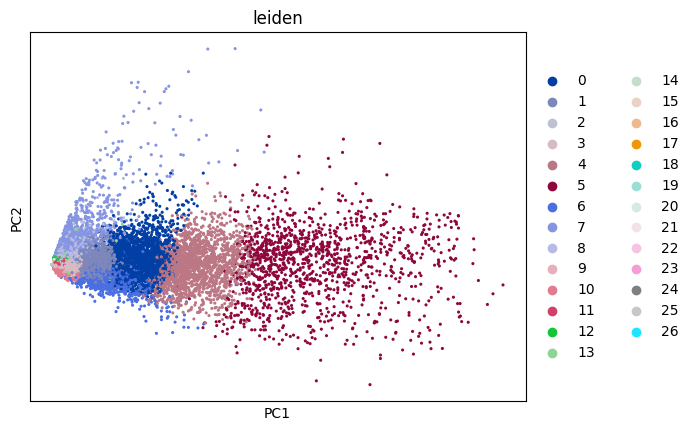

In [21]:
sc.pl.pca(
    adata,
    color=['leiden'],
    size=20
)

Save the clustering results

In [22]:
celltypist_markers_df = pd.DataFrame(adata.obs['leiden'])
celltypist_markers_df = celltypist_markers_df.rename(columns={'leiden': 'cluster'})
celltypist_markers_df.index.name = 'cell'
celltypist_markers_df['cluster'] = celltypist_markers_df['cluster'].astype(int) + 1
celltypist_markers_df.to_csv(f'{celltypist_path}/clustering_labels.csv', index=True)
celltypist_num_clusters = len(celltypist_markers_df['cluster'].unique())

## Differential expression on clusters tuned according to celltypist

In [23]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # default='t-test', wilcoxon suggested in the tutorial

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

Save markers

In [29]:
celltypist_markers_df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
for i in range(celltypist_num_clusters):
    indices = np.argsort(adata.uns['rank_genes_groups']['pvals_adj'][str(i)])
    genes = adata.uns['rank_genes_groups']['names'][str(i)][indices][:top_number_of_markers]
    ranks = rankdata(adata.uns['rank_genes_groups']['pvals_adj'][str(i)][indices][:top_number_of_markers], method="ordinal")
    temp_df = pd.DataFrame(
        np.column_stack((genes, [i+1 for _ in range(top_number_of_markers)], ranks)),
        columns=['gene', 'cluster', 'rank']
    )
    celltypist_markers_df = pd.concat([celltypist_markers_df, temp_df], ignore_index=True)

celltypist_markers_df['cluster'] = celltypist_markers_df['cluster'].astype(int)
celltypist_markers_df['rank'] = celltypist_markers_df['rank'].astype(int)
celltypist_markers_df.to_csv(f'{celltypist_path}/markers.csv', index=False)